# ***Redes Neuronales***

## **Librerías y carga de datos**


In [ ]:
!pip install -q tqdm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pickle
from tensorflow.keras.layers import (Embedding, Bidirectional, LSTM,
                                     Dense, Dropout)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             ConfusionMatrixDisplay,
                             precision_recall_curve, roc_auc_score, roc_curve,  ConfusionMatrixDisplay,  )
from tensorflow.keras.models import save_model
import joblib

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
root_dir = '/content/drive/MyDrive/PDG/data/'
export_dir = '/content/drive/MyDrive/PDG/models/'
#root_dir = "/content/drive/MyDrive/Proyecto-de-Grado-RAD-Alert/Oficial/Ahora-si-este-fue/data/"

In [ ]:
file_original = root_dir + "base_df.xlsx"
file_aug_train = root_dir + "train_oversample_df.xlsx"
file_aug_val  = root_dir + "val_df.xlsx"

## **Preprocesamiento**

In [ ]:
TEXT    = "texto"
LABEL   = "etiqueta"
VOCAB   = 30_000
MAXLEN  = 250
EMB_DIM = 128
BATCH   = 64
EPOCHS  = 12

In [ ]:
def build_lstm(vocab=VOCAB, maxlen=MAXLEN, emb_dim=EMB_DIM):
    model = Sequential([
        Embedding(vocab, emb_dim, input_length=maxlen),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model


In [ ]:
def prep_text(train_text, test_text, vocab=VOCAB, maxlen=MAXLEN):
    tok = Tokenizer(num_words=vocab, oov_token="<OOV>")
    tok.fit_on_texts(train_text)
    Xtr = pad_sequences(tok.texts_to_sequences(train_text), maxlen=maxlen, padding="post")
    Xte = pad_sequences(tok.texts_to_sequences(test_text),  maxlen=maxlen, padding="post")
    return Xtr, Xte

## Definición Modelo

In [ ]:
def train_and_eval(name, df_tr, df_te):
    print(f"\n>>> {name.upper()} <<<")
    Xtr_text, ytr = df_tr[TEXT].astype(str), df_tr[LABEL].astype(int).values
    Xte_text, yte = df_te[TEXT].astype(str), df_te[LABEL].astype(int).values

    Xtr, Xte = prep_text(Xtr_text, Xte_text)

    model = build_lstm()
    es = EarlyStopping(patience=2, restore_best_weights=True, verbose=1)
    model.fit(
        Xtr, ytr,
        epochs=EPOCHS,
        batch_size=BATCH,
        validation_split=0.1,
        callbacks=[es],
        verbose=2
    )

    y_prob = model.predict(Xte, batch_size=BATCH).ravel()
    prec, rec, thr = precision_recall_curve(yte, y_prob)
    f1 = 2 * prec * rec / (prec + rec + 1e-9)
    best_thr = thr[np.nanargmax(f1)]
    y_pred = (y_prob >= best_thr).astype(int)
    print(f"Umbral óptimo F1: {best_thr:.3f}\n")
    print(classification_report(yte, y_pred, digits=3))

    cm = confusion_matrix(yte, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No crítico","Crítico"]).plot(cmap="Blues")
    plt.title(f"CM – {name}"); plt.show()

    auc = roc_auc_score(yte, y_prob)
    fpr, tpr, _ = roc_curve(yte, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}"); plt.plot([0,1],[0,1],"k--")
    plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC – {name}")
    plt.legend(); plt.show()

    return model

## **Evaluación Modelos**


>>> ORIGINAL <<<
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


38/38 - 52s - 1s/step - accuracy: 0.8203 - loss: 0.4157 - val_accuracy: 0.8295 - val_loss: 0.3100
Epoch 2/12
38/38 - 81s - 2s/step - accuracy: 0.8890 - loss: 0.2453 - val_accuracy: 0.8788 - val_loss: 0.3199
Epoch 3/12
38/38 - 39s - 1s/step - accuracy: 0.9262 - loss: 0.1906 - val_accuracy: 0.8977 - val_loss: 0.2498
Epoch 4/12
38/38 - 42s - 1s/step - accuracy: 0.9603 - loss: 0.1233 - val_accuracy: 0.8939 - val_loss: 0.3013
Epoch 5/12
38/38 - 43s - 1s/step - accuracy: 0.9759 - loss: 0.0892 - val_accuracy: 0.9091 - val_loss: 0.3109
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 354ms/step
Umbral óptimo F1: 0.477

              precision    recall  f1-score   support

           0      0.957     0.950     0.953       535
           1      0.789     0.815     0.802       124

    accuracy                          0.924       659
   macro avg      0.873     0.882     0.877       659
weighted avg      0.925     0.924     0.925  

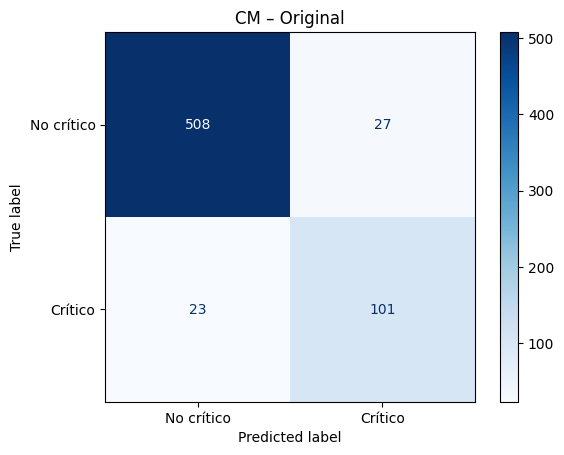

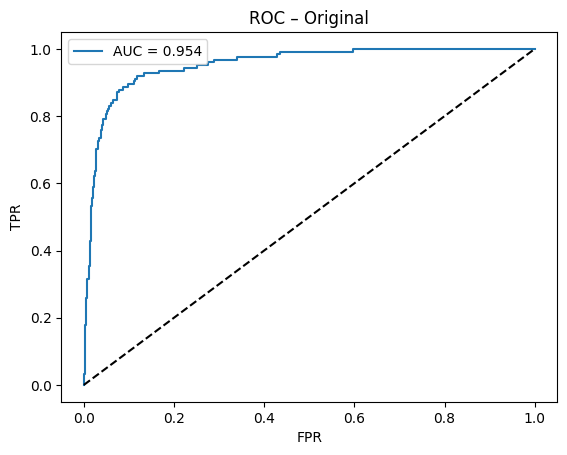

In [ ]:
df_orig = pd.read_excel(file_original)
df_o_tr, df_o_te = train_test_split(
    df_orig, test_size=0.2, stratify=df_orig[LABEL], random_state=42
)

model_orig = train_and_eval("Original", df_o_tr, df_o_te)


>>> AUMENTADO_BALANCEADO <<<
Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


48/48 - 71s - 1s/step - accuracy: 0.8279 - loss: 0.4165 - val_accuracy: 0.9410 - val_loss: 0.1638
Epoch 2/12
48/48 - 56s - 1s/step - accuracy: 0.9507 - loss: 0.1401 - val_accuracy: 0.9263 - val_loss: 0.2115
Epoch 3/12
48/48 - 54s - 1s/step - accuracy: 0.9704 - loss: 0.0960 - val_accuracy: 0.9204 - val_loss: 0.2096
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step
Umbral óptimo F1: 0.290

              precision    recall  f1-score   support

           0      0.942     0.935     0.938       535
           1      0.727     0.750     0.738       124

    accuracy                          0.900       659
   macro avg      0.834     0.842     0.838       659
weighted avg      0.901     0.900     0.900       659



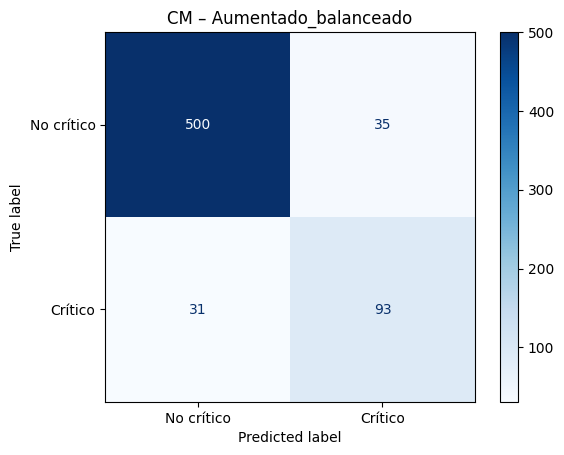

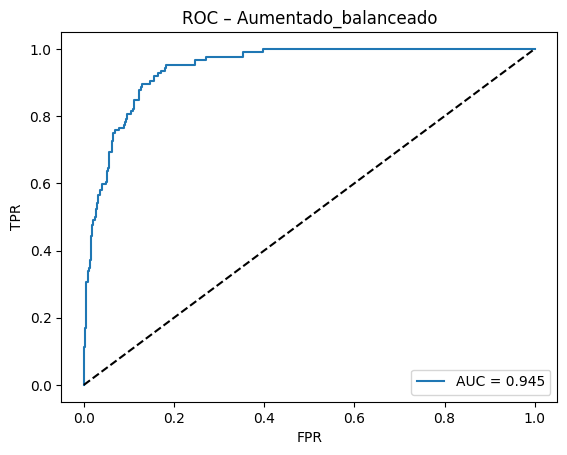

In [ ]:
df_aug_tr = pd.read_excel(file_aug_train)
df_aug_te = pd.read_excel(file_aug_val)

model_aug  = train_and_eval("Aumentado_balanceado", df_aug_tr, df_aug_te)

## **Exportación de Modelos**

In [ ]:
model_orig.save(export_dir + "lstm_base.keras",   include_optimizer=False)
model_aug .save(export_dir + "lstm_aug.keras",    include_optimizer=False)

# guarda también el tokenizer que entrenaste sobre cada corpus
joblib.dump(tok_orig, export_dir + "tok_base.pkl")
joblib.dump(tok_aug , export_dir + "tok_aug.pkl")
print("✔ Modelos y tokenizers guardados")

In [ ]:
import json, datetime, tensorflow as tf
meta = {
    "threshold": float(best_thr),
    "date": datetime.datetime.now().isoformat(),
    "tf_version": tf.__version__,
    "vocab": VOCAB,
    "maxlen": MAXLEN
}
with open(export_dir+"meta_aug.json","w") as fp:
    json.dump(meta, fp, indent=2)
